In [9]:
import pandas as pd
import numpy as np

# Load the LTCM data from Exhibit 2
# Skip the first 3 rows (copyright and header info)
ltcm_data = pd.read_excel('ltcm_exhibits_data.xlsx', sheet_name='Exhibit 2', skiprows=3)

# Clean the data - remove any rows with missing values
ltcm_data = ltcm_data.dropna()

# Set proper column names first
ltcm_data.columns = ['Date', 'Fund_Capital_Billions', 'Gross_Monthly_Performance', 
                     'Net_Monthly_Performance', 'Index_Net_Performance']

# Convert date column to datetime AFTER setting column names
ltcm_data['Date'] = pd.to_datetime(ltcm_data['Date'])

# Load SPY data to get the treasury bill rates
spy_data = pd.read_excel('spy_data.xlsx', sheet_name='prices')

# Convert date to datetime
spy_data['date'] = pd.to_datetime(spy_data['date'])

# Extract year-month for merging
ltcm_data['YearMonth'] = ltcm_data['Date'].dt.to_period('M')
spy_data['YearMonth'] = spy_data['date'].dt.to_period('M')

# Get monthly risk-free rate from ^IRX (13-week T-bill)
# Convert annual rate to monthly: divide by 12
spy_monthly = spy_data.groupby('YearMonth').first().reset_index()
spy_monthly['Monthly_RF_Rate'] = spy_monthly['^IRX'] / 100 / 12

# Merge LTCM data with risk-free rates
ltcm_merged = ltcm_data.merge(spy_monthly[['YearMonth', 'Monthly_RF_Rate']], 
                               on='YearMonth', how='left')

# Calculate excess returns
ltcm_merged['Gross_Excess_Return'] = ltcm_merged['Gross_Monthly_Performance'] - ltcm_merged['Monthly_RF_Rate']
ltcm_merged['Net_Excess_Return'] = ltcm_merged['Net_Monthly_Performance'] - ltcm_merged['Monthly_RF_Rate']

# Function to calculate annualized statistics
def calculate_statistics(returns, name):
    """
    Calculate annualized mean, volatility, Sharpe ratio, skewness, kurtosis, and 5th quantile
    
    Parameters:
    returns: Series of monthly returns
    name: String identifier for the return series
    
    Returns:
    Dictionary with calculated statistics
    """
    # Annualized mean (simple multiplication by 12)
    annualized_mean = returns.mean() * 12
    
    # Annualized volatility (monthly std * sqrt(12))
    annualized_vol = returns.std() * np.sqrt(12)
    
    # Sharpe ratio (annualized mean / annualized volatility)
    sharpe_ratio = annualized_mean / annualized_vol if annualized_vol != 0 else 0
    
    # Skewness
    skewness = returns.skew()
    
    # Excess kurtosis
    kurtosis = returns.kurtosis()
    
    # 5th percentile
    fifth_quantile = returns.quantile(0.05)
    
    return {
        'Series': name,
        'Annualized Mean': annualized_mean,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Skewness': skewness,
        'Excess Kurtosis': kurtosis,
        '5th Percentile': fifth_quantile
    }

# Calculate statistics for gross excess returns
gross_stats = calculate_statistics(ltcm_merged['Gross_Excess_Return'], 'Gross Excess Returns')

# Calculate statistics for net excess returns
net_stats = calculate_statistics(ltcm_merged['Net_Excess_Return'], 'Net Excess Returns')

# Create summary DataFrame
summary_stats = pd.DataFrame([gross_stats, net_stats])

# Display results
print("="*80)
print("LTCM EXCESS RETURNS - SUMMARY STATISTICS")
print("="*80)
print("\n", summary_stats.to_string(index=False))
print("\n" + "="*80)

# Additional detailed output
print("\nDetailed Statistics:")
print("\nGROSS EXCESS RETURNS:")
for key, value in gross_stats.items():
    if key != 'Series':
        print(f"  {key}: {value:.6f}")

print("\nNET EXCESS RETURNS:")
for key, value in net_stats.items():
    if key != 'Series':
        print(f"  {key}: {value:.6f}")

# Optional: Save results to Excel
with pd.ExcelWriter('ltcm_summary_statistics.xlsx') as writer:
    summary_stats.to_excel(writer, sheet_name='Summary Statistics', index=False)
    ltcm_merged.to_excel(writer, sheet_name='Data with Excess Returns', index=False)

print("\nResults saved to 'ltcm_summary_statistics.xlsx'")

LTCM EXCESS RETURNS - SUMMARY STATISTICS

               Series  Annualized Mean  Annualized Volatility  Sharpe Ratio  Skewness  Excess Kurtosis  5th Percentile
Gross Excess Returns         0.243600               0.136238       1.78805 -0.288328         1.586681       -0.030305
  Net Excess Returns         0.156883               0.111773       1.40359 -0.810870         2.927724       -0.026300


Detailed Statistics:

GROSS EXCESS RETURNS:
  Annualized Mean: 0.243600
  Annualized Volatility: 0.136238
  Sharpe Ratio: 1.788050
  Skewness: -0.288328
  Excess Kurtosis: 1.586681
  5th Percentile: -0.030305

NET EXCESS RETURNS:
  Annualized Mean: 0.156883
  Annualized Volatility: 0.111773
  Sharpe Ratio: 1.403590
  Skewness: -0.810870
  Excess Kurtosis: 2.927724
  5th Percentile: -0.026300

Results saved to 'ltcm_summary_statistics.xlsx'


In [10]:
# ============================================================================
# 2. Compare to SPY
# ============================================================================

print("\n" + "="*80)
print("2. COMPARISON WITH SPY")
print("="*80)

# Load SPY total returns data
spy_returns = pd.read_excel('spy_data.xlsx', sheet_name='total returns')
spy_returns['date'] = pd.to_datetime(spy_returns['date'])
spy_returns['YearMonth'] = spy_returns['date'].dt.to_period('M')

# Filter SPY returns for the same period as LTCM (1994-03 to 1998-07)
ltcm_start = ltcm_merged['YearMonth'].min()
ltcm_end = ltcm_merged['YearMonth'].max()
spy_returns_filtered = spy_returns[(spy_returns['YearMonth'] >= ltcm_start) & 
                                    (spy_returns['YearMonth'] <= ltcm_end)]

# Calculate SPY excess returns
spy_merged = spy_returns_filtered.merge(spy_monthly[['YearMonth', 'Monthly_RF_Rate']], 
                                        on='YearMonth', how='left')
spy_merged['SPY_Excess_Return'] = spy_merged['SPY'] - spy_merged['Monthly_RF_Rate']

# Calculate SPY statistics
spy_stats = calculate_statistics(spy_merged['SPY_Excess_Return'], 'SPY Excess Returns')

# Create comparison table
comparison_df = pd.DataFrame([gross_stats, net_stats, spy_stats])

print("\nComparison Table:")
print(comparison_df.to_string(index=False))

# Calculate differences between gross and net
print("\n" + "-"*80)
print("Difference between Gross and Net LTCM Returns:")
print("-"*80)
print(f"Annualized Mean difference: {gross_stats['Annualized Mean'] - net_stats['Annualized Mean']:.6f}")
print(f"  (Represents management fees impact: {(gross_stats['Annualized Mean'] - net_stats['Annualized Mean'])*100:.2f}%)")
print(f"Annualized Volatility difference: {gross_stats['Annualized Volatility'] - net_stats['Annualized Volatility']:.6f}")
print(f"Sharpe Ratio difference: {gross_stats['Sharpe Ratio'] - net_stats['Sharpe Ratio']:.6f}")

# Commentary
print("\n" + "-"*80)
print("COMMENTARY:")
print("-"*80)
print(f"1. Return Comparison:")
print(f"   - LTCM Net Annualized Return: {net_stats['Annualized Mean']*100:.2f}%")
print(f"   - SPY Annualized Return: {spy_stats['Annualized Mean']*100:.2f}%")
print(f"   - LTCM outperformed SPY by: {(net_stats['Annualized Mean'] - spy_stats['Annualized Mean'])*100:.2f}%")

print(f"\n2. Volatility Comparison:")
print(f"   - LTCM Net Annualized Volatility: {net_stats['Annualized Volatility']*100:.2f}%")
print(f"   - SPY Annualized Volatility: {spy_stats['Annualized Volatility']*100:.2f}%")
print(f"   - LTCM is {'less' if net_stats['Annualized Volatility'] < spy_stats['Annualized Volatility'] else 'more'} volatile than SPY")

print(f"\n3. Sharpe Ratio Comparison:")
print(f"   - LTCM Net Sharpe Ratio: {net_stats['Sharpe Ratio']:.3f}")
print(f"   - SPY Sharpe Ratio: {spy_stats['Sharpe Ratio']:.3f}")
print(f"   - LTCM has {'superior' if net_stats['Sharpe Ratio'] > spy_stats['Sharpe Ratio'] else 'inferior'} risk-adjusted returns")

print(f"\n4. Gross vs Net LTCM:")
print(f"   - Fee impact on returns: {(gross_stats['Annualized Mean'] - net_stats['Annualized Mean'])*100:.2f}% per year")
print(f"   - Fee impact on Sharpe: {gross_stats['Sharpe Ratio'] - net_stats['Sharpe Ratio']:.3f}")




2. COMPARISON WITH SPY

Comparison Table:
              Series  Annualized Mean  Annualized Volatility  Sharpe Ratio  Skewness  Excess Kurtosis  5th Percentile
Gross Excess Returns         0.243600               0.136238      1.788050 -0.288328         1.586681       -0.030305
  Net Excess Returns         0.156883               0.111773      1.403590 -0.810870         2.927724       -0.026300
  SPY Excess Returns         0.154775               0.114073      1.356806 -0.406867        -0.388002       -0.049667

--------------------------------------------------------------------------------
Difference between Gross and Net LTCM Returns:
--------------------------------------------------------------------------------
Annualized Mean difference: 0.086717
  (Represents management fees impact: 8.67%)
Annualized Volatility difference: 0.024465
Sharpe Ratio difference: 0.384460

--------------------------------------------------------------------------------
COMMENTARY:
----------------------


3. LINEAR FACTOR DECOMPOSITION

Regression Results:
--------------------------------------------------------------------------------
Model: LTCM_Net_Excess = α + β × SPY_Excess + ε

Annualized Alpha (α): 0.135076 (13.51%)
Monthly Alpha: 0.011256 (1.13%)

Beta (β): 0.140892
  t-statistic: 1.038
  p-value: 0.3043
  Significance: No (p >= 0.05)

R-squared: 0.020676 (2.07%)

--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------

1. Alpha Analysis:
   - LTCM generated positive annualized alpha of 13.51%
   - This suggests LTCM delivered 13.51% annual returns BEYOND SPY

2. Beta Analysis:
   - Beta of 0.141 indicates VERY LOW correlation with SPY
   - LTCM's returns were largely independent of stock market movements

3. R-squared Analysis:
   - Only 2.07% of LTCM's return variation is explained by SPY
   - 97.93% comes from OTHER sources (arbitrage strategies, etc.)

4

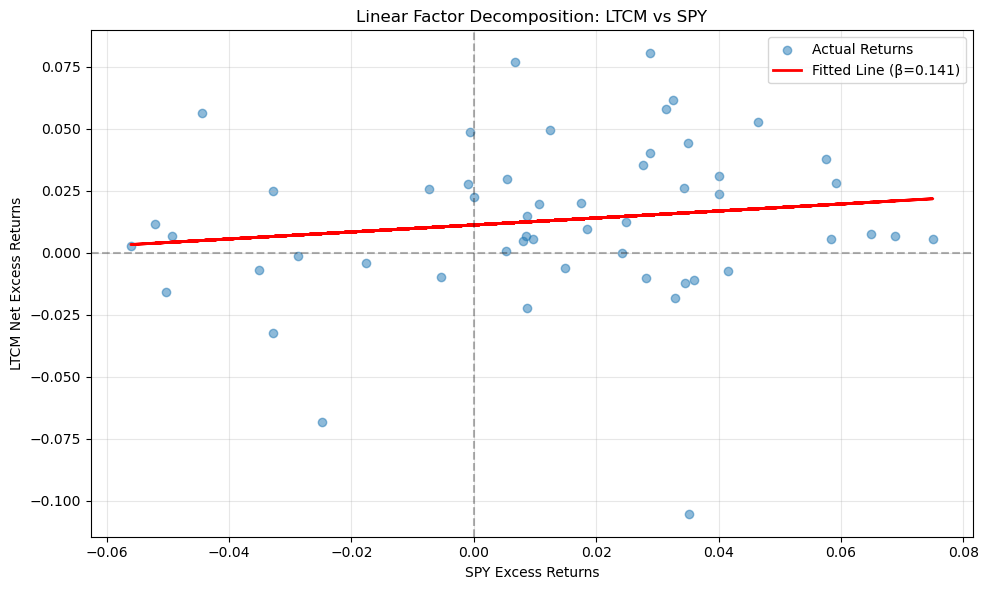

In [13]:
# ============================================================================
# 3. Linear Factor Decomposition (LFD)
# ============================================================================

print("\n" + "="*80)
print("3. LINEAR FACTOR DECOMPOSITION")
print("="*80)

# Merge LTCM and SPY excess returns for regression
regression_data = ltcm_merged[['YearMonth', 'Net_Excess_Return']].merge(
    spy_merged[['YearMonth', 'SPY_Excess_Return']], 
    on='YearMonth', how='inner')

# Remove any missing values
regression_data = regression_data.dropna()

# Perform linear regression: LTCM_net = alpha + beta * SPY + epsilon
from sklearn.linear_model import LinearRegression
from scipy import stats

X = regression_data['SPY_Excess_Return'].values.reshape(-1, 1)
y = regression_data['Net_Excess_Return'].values

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Get regression coefficients
beta = model.coef_[0]
monthly_alpha = model.intercept_

# Annualize alpha using simple multiplication: monthly_alpha * 12
annualized_alpha = monthly_alpha * 12

# Calculate R-squared
y_pred = model.predict(X)
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

# Calculate statistics for significance testing
n = len(y)
residuals = y - y_pred
residual_std = np.sqrt(np.sum(residuals**2) / (n - 2))
x_mean = np.mean(X)
se_beta = residual_std / np.sqrt(np.sum((X - x_mean)**2))
t_stat_beta = beta / se_beta
p_value_beta = 2 * (1 - stats.t.cdf(abs(t_stat_beta), n - 2))

# Print results
print("\nRegression Results:")
print("-"*80)
print(f"Model: LTCM_Net_Excess = α + β × SPY_Excess + ε")
print(f"\nAnnualized Alpha (α): {annualized_alpha:.6f} ({annualized_alpha*100:.2f}%)")
print(f"Monthly Alpha: {monthly_alpha:.6f} ({monthly_alpha*100:.2f}%)")
print(f"\nBeta (β): {beta:.6f}")
print(f"  t-statistic: {t_stat_beta:.3f}")
print(f"  p-value: {p_value_beta:.4f}")
print(f"  Significance: {'Yes (p < 0.05)' if p_value_beta < 0.05 else 'No (p >= 0.05)'}")
print(f"\nR-squared: {r_squared:.6f} ({r_squared*100:.2f}%)")

# Interpretation
print("\n" + "-"*80)
print("INTERPRETATION:")
print("-"*80)
print(f"\n1. Alpha Analysis:")
if annualized_alpha > 0:
    print(f"   - LTCM generated positive annualized alpha of {annualized_alpha*100:.2f}%")
    print(f"   - This suggests LTCM delivered {annualized_alpha*100:.2f}% annual returns BEYOND SPY")
else:
    print(f"   - LTCM generated negative annualized alpha of {annualized_alpha*100:.2f}%")

print(f"\n2. Beta Analysis:")
if abs(beta) < 0.3:
    print(f"   - Beta of {beta:.3f} indicates VERY LOW correlation with SPY")
    print(f"   - LTCM's returns were largely independent of stock market movements")
elif abs(beta) < 0.7:
    print(f"   - Beta of {beta:.3f} indicates MODERATE correlation with SPY")
else:
    print(f"   - Beta of {beta:.3f} indicates HIGH correlation with SPY")

print(f"\n3. R-squared Analysis:")
print(f"   - Only {r_squared*100:.2f}% of LTCM's return variation is explained by SPY")
print(f"   - {(1-r_squared)*100:.2f}% comes from OTHER sources (arbitrage strategies, etc.)")

print(f"\n4. Does LTCM deliver performance beyond SPY?")
if annualized_alpha > 0 and r_squared < 0.5:
    print(f"   YES - LTCM delivered:")
    print(f"   • Positive alpha of {annualized_alpha*100:.2f}% per year")
    print(f"   • Low R² ({r_squared*100:.1f}%) shows returns are NOT simply from equity exposure")
    print(f"   • This represents genuine 'alpha' from arbitrage strategies")
else:
    print(f"   MIXED - Need to consider:")
    print(f"   • Alpha: {annualized_alpha*100:.2f}%")
    print(f"   • R²: {r_squared*100:.1f}%")

# Visualize the regression (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Actual Returns')
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Fitted Line (β={beta:.3f})')
plt.xlabel('SPY Excess Returns')
plt.ylabel('LTCM Net Excess Returns')
plt.title('Linear Factor Decomposition: LTCM vs SPY')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('ltcm_lfd_regression.png', dpi=300, bbox_inches='tight')
print("\nRegression plot saved as 'ltcm_lfd_regression.png'")

# Save all results to Excel
with pd.ExcelWriter('ltcm_complete_analysis.xlsx') as writer:
    summary_stats.to_excel(writer, sheet_name='Summary Statistics', index=False)
    comparison_df.to_excel(writer, sheet_name='Comparison with SPY', index=False)
    
    # Regression results
    regression_results = pd.DataFrame({
        'Metric': ['Annualized Alpha', 'Monthly Alpha', 'Beta', 'R-squared', 
                   'Beta t-statistic', 'Beta p-value'],
        'Value': [annualized_alpha, monthly_alpha, beta, r_squared, t_stat_beta, p_value_beta]
    })
    regression_results.to_excel(writer, sheet_name='Regression Results', index=False)
    
    regression_data.to_excel(writer, sheet_name='Regression Data', index=False)

print("\nComplete analysis saved to 'ltcm_complete_analysis.xlsx'")
print("="*80)


4. NONLINEAR EXPOSURE ANALYSIS

Nonlinear Regression Results:
--------------------------------------------------------------------------------
Model: LTCM_Net_Excess = α + β_linear × SPY_Excess + β_quad × (SPY_Excess)² + ε

Annualized Alpha (α): 0.162629 (16.26%)
Monthly Alpha: 0.013552 (1.36%)
  t-statistic: 2.217
  p-value: 0.0312
  Significance: **

Linear Beta (β_linear): 0.168741
  t-statistic: 1.170
  p-value: 0.2474
  Significance: No

Quadratic Beta (β_quad): -2.158255
  t-statistic: -0.605
  p-value: 0.5477
  Significance: No

R-squared: 0.027801 (2.78%)

--------------------------------------------------------------------------------
Comparison: Linear vs Nonlinear Model
--------------------------------------------------------------------------------
Linear Model R²: 0.020676 (2.07%)
Nonlinear Model R²: 0.027801 (2.78%)
Improvement in R²: 0.007125 (0.71 percentage points)

--------------------------------------------------------------------------------
INTERPRETATION:
------

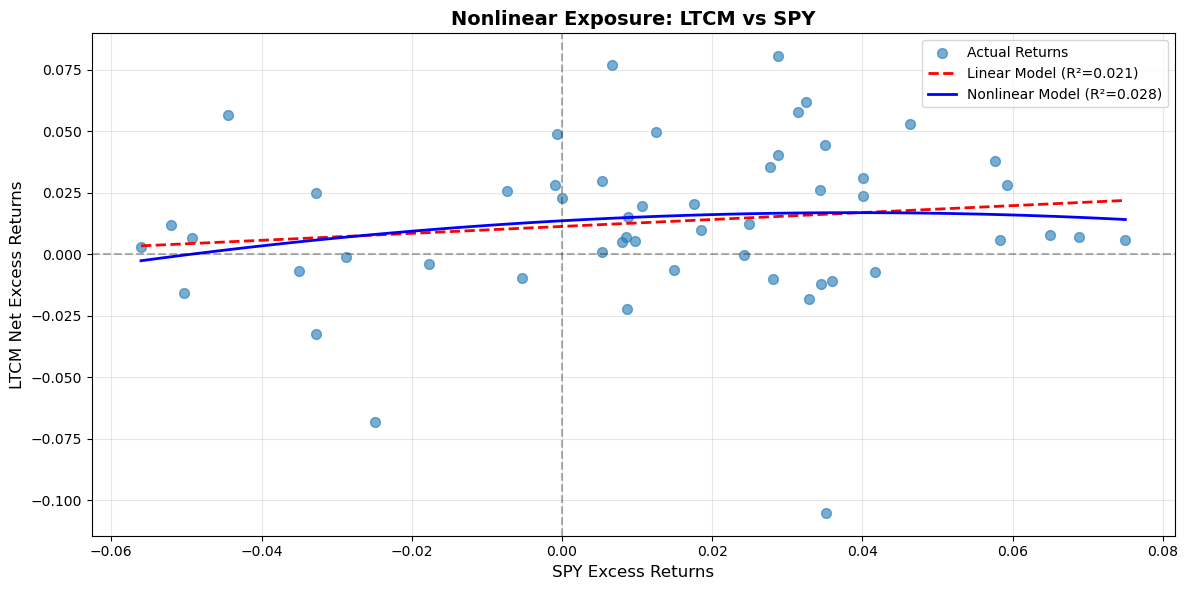

In [15]:
# ============================================================================
# 4. Nonlinear Exposure
# ============================================================================

print("\n" + "="*80)
print("4. NONLINEAR EXPOSURE ANALYSIS")
print("="*80)

# Prepare data for nonlinear regression
# We already have regression_data with LTCM and SPY excess returns

# Create the squared term for SPY excess returns
regression_data['SPY_Excess_Squared'] = regression_data['SPY_Excess_Return']**2

# Prepare variables for regression
X_nonlinear = regression_data[['SPY_Excess_Return', 'SPY_Excess_Squared']].values
y_nonlinear = regression_data['Net_Excess_Return'].values

# Fit the nonlinear model
model_nonlinear = LinearRegression()
model_nonlinear.fit(X_nonlinear, y_nonlinear)

# Get regression coefficients
beta_linear = model_nonlinear.coef_[0]
beta_quad = model_nonlinear.coef_[1]
monthly_alpha_nl = model_nonlinear.intercept_

# Annualize alpha using compounding
annualized_alpha_nl =  monthly_alpha_nl*12 

# Calculate R-squared
y_pred_nl = model_nonlinear.predict(X_nonlinear)
ss_total_nl = np.sum((y_nonlinear - np.mean(y_nonlinear))**2)
ss_residual_nl = np.sum((y_nonlinear - y_pred_nl)**2)
r_squared_nl = 1 - (ss_residual_nl / ss_total_nl)

# Calculate statistics for significance testing
n_nl = len(y_nonlinear)
residuals_nl = y_nonlinear - y_pred_nl
residual_std_nl = np.sqrt(np.sum(residuals_nl**2) / (n_nl - 3))  # 3 parameters

# Calculate standard errors using matrix algebra
X_with_intercept = np.column_stack([np.ones(n_nl), X_nonlinear])
XtX_inv = np.linalg.inv(X_with_intercept.T @ X_with_intercept)
var_coef = residual_std_nl**2 * XtX_inv

se_alpha = np.sqrt(var_coef[0, 0])
se_beta_linear = np.sqrt(var_coef[1, 1])
se_beta_quad = np.sqrt(var_coef[2, 2])

# t-statistics and p-values
t_stat_alpha = monthly_alpha_nl / se_alpha
t_stat_beta_linear = beta_linear / se_beta_linear
t_stat_beta_quad = beta_quad / se_beta_quad

p_value_alpha = 2 * (1 - stats.t.cdf(abs(t_stat_alpha), n_nl - 3))
p_value_beta_linear = 2 * (1 - stats.t.cdf(abs(t_stat_beta_linear), n_nl - 3))
p_value_beta_quad = 2 * (1 - stats.t.cdf(abs(t_stat_beta_quad), n_nl - 3))

# Print results
print("\nNonlinear Regression Results:")
print("-"*80)
print(f"Model: LTCM_Net_Excess = α + β_linear × SPY_Excess + β_quad × (SPY_Excess)² + ε")
print(f"\nAnnualized Alpha (α): {annualized_alpha_nl:.6f} ({annualized_alpha_nl*100:.2f}%)")
print(f"Monthly Alpha: {monthly_alpha_nl:.6f} ({monthly_alpha_nl*100:.2f}%)")
print(f"  t-statistic: {t_stat_alpha:.3f}")
print(f"  p-value: {p_value_alpha:.4f}")
print(f"  Significance: {'***' if p_value_alpha < 0.01 else '**' if p_value_alpha < 0.05 else '*' if p_value_alpha < 0.1 else 'No'}")

print(f"\nLinear Beta (β_linear): {beta_linear:.6f}")
print(f"  t-statistic: {t_stat_beta_linear:.3f}")
print(f"  p-value: {p_value_beta_linear:.4f}")
print(f"  Significance: {'***' if p_value_beta_linear < 0.01 else '**' if p_value_beta_linear < 0.05 else '*' if p_value_beta_linear < 0.1 else 'No'}")

print(f"\nQuadratic Beta (β_quad): {beta_quad:.6f}")
print(f"  t-statistic: {t_stat_beta_quad:.3f}")
print(f"  p-value: {p_value_beta_quad:.4f}")
print(f"  Significance: {'***' if p_value_beta_quad < 0.01 else '**' if p_value_beta_quad < 0.05 else '*' if p_value_beta_quad < 0.1 else 'No'}")

print(f"\nR-squared: {r_squared_nl:.6f} ({r_squared_nl*100:.2f}%)")

# Compare with linear model
print("\n" + "-"*80)
print("Comparison: Linear vs Nonlinear Model")
print("-"*80)
print(f"Linear Model R²: {r_squared:.6f} ({r_squared*100:.2f}%)")
print(f"Nonlinear Model R²: {r_squared_nl:.6f} ({r_squared_nl*100:.2f}%)")
print(f"Improvement in R²: {(r_squared_nl - r_squared):.6f} ({(r_squared_nl - r_squared)*100:.2f} percentage points)")

# Interpretation
print("\n" + "-"*80)
print("INTERPRETATION:")
print("-"*80)

print(f"\n1. Quadratic Term (β_quad = {beta_quad:.6f}):")
if abs(beta_quad) < 0.001:
    print(f"   - Very small quadratic coefficient suggests minimal nonlinear exposure")
elif beta_quad > 0:
    print(f"   - POSITIVE quadratic term suggests:")
    print(f"     • LTCM gains more in extreme market movements (both up and down)")
    print(f"     • Similar to a 'long volatility' or 'long straddle' position")
    print(f"     • Benefits from market turbulence")
else:
    print(f"   - NEGATIVE quadratic term suggests:")
    print(f"     • LTCM loses more in extreme market movements")
    print(f"     • Similar to a 'short volatility' or 'short straddle' position")
    print(f"     • Vulnerable to market turbulence (like August 1998 crisis!)")

print(f"\n2. Statistical Significance:")
if p_value_beta_quad < 0.05:
    print(f"   - Quadratic term IS statistically significant (p = {p_value_beta_quad:.4f})")
    print(f"   - Strong evidence of nonlinear market exposure")
else:
    print(f"   - Quadratic term is NOT statistically significant (p = {p_value_beta_quad:.4f})")
    print(f"   - Limited evidence of nonlinear exposure")

print(f"\n3. Model Improvement:")
improvement_pct = ((r_squared_nl - r_squared) / r_squared) * 100 if r_squared > 0 else 0
if r_squared_nl > r_squared + 0.05:
    print(f"   - R² improved by {improvement_pct:.1f}% - substantial improvement")
    print(f"   - Nonlinear term adds meaningful explanatory power")
elif r_squared_nl > r_squared:
    print(f"   - R² improved by {improvement_pct:.1f}% - modest improvement")
    print(f"   - Some nonlinear exposure present but not dominant")
else:
    print(f"   - No improvement in R² - nonlinear term not useful")

print(f"\n4. Risk Implications:")
if beta_quad < 0 and p_value_beta_quad < 0.1:
    print(f"   ⚠️  WARNING: Negative quadratic exposure suggests:")
    print(f"   - LTCM is 'short volatility' - selling insurance/options")
    print(f"   - Earns steady returns in normal times")
    print(f"   - VULNERABLE to market crashes (like 1998!)")
    print(f"   - This is consistent with LTCM's actual collapse")
elif beta_quad > 0 and p_value_beta_quad < 0.1:
    print(f"   - Positive quadratic exposure suggests protection in extreme events")
    print(f"   - LTCM benefits from volatility")
else:
    print(f"   - No significant nonlinear exposure detected")

# Visualize the nonlinear relationship
plt.figure(figsize=(12, 6))

# Sort data for smooth plotting
sort_idx = np.argsort(regression_data['SPY_Excess_Return'].values)
X_sorted = regression_data['SPY_Excess_Return'].values[sort_idx]
y_sorted = regression_data['Net_Excess_Return'].values[sort_idx]

# Predictions for plotting
X_range = np.linspace(X_sorted.min(), X_sorted.max(), 100)
X_range_linear = X_range.reshape(-1, 1)
X_range_nonlinear = np.column_stack([X_range, X_range**2])

y_pred_linear_plot = model.predict(X_range_linear)
y_pred_nonlinear_plot = model_nonlinear.predict(X_range_nonlinear)

plt.scatter(regression_data['SPY_Excess_Return'], 
           regression_data['Net_Excess_Return'], 
           alpha=0.6, s=50, label='Actual Returns')
plt.plot(X_range, y_pred_linear_plot, 'r--', linewidth=2, 
         label=f'Linear Model (R²={r_squared:.3f})')
plt.plot(X_range, y_pred_nonlinear_plot, 'b-', linewidth=2, 
         label=f'Nonlinear Model (R²={r_squared_nl:.3f})')
plt.xlabel('SPY Excess Returns', fontsize=12)
plt.ylabel('LTCM Net Excess Returns', fontsize=12)
plt.title('Nonlinear Exposure: LTCM vs SPY', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('ltcm_nonlinear_exposure.png', dpi=300, bbox_inches='tight')
print("\nNonlinear exposure plot saved as 'ltcm_nonlinear_exposure.png'")

# Save nonlinear results to Excel
with pd.ExcelWriter('ltcm_complete_analysis.xlsx', mode='a', if_sheet_exists='replace') as writer:
    # Previous sheets
    summary_stats.to_excel(writer, sheet_name='Summary Statistics', index=False)
    comparison_df.to_excel(writer, sheet_name='Comparison with SPY', index=False)
    
    # Linear regression results
    linear_regression_results = pd.DataFrame({
        'Metric': ['Annualized Alpha', 'Monthly Alpha', 'Beta', 'R-squared', 
                   'Beta t-statistic', 'Beta p-value'],
        'Value': [annualized_alpha, monthly_alpha, beta, r_squared, t_stat_beta, p_value_beta]
    })
    linear_regression_results.to_excel(writer, sheet_name='Linear Regression', index=False)
    
    # Nonlinear regression results
    nonlinear_regression_results = pd.DataFrame({
        'Metric': ['Annualized Alpha', 'Monthly Alpha', 'Beta Linear', 'Beta Quadratic', 
                   'R-squared', 'Alpha t-stat', 'Linear t-stat', 'Quad t-stat',
                   'Alpha p-value', 'Linear p-value', 'Quad p-value'],
        'Value': [annualized_alpha_nl, monthly_alpha_nl, beta_linear, beta_quad, 
                  r_squared_nl, t_stat_alpha, t_stat_beta_linear, t_stat_beta_quad,
                  p_value_alpha, p_value_beta_linear, p_value_beta_quad]
    })
    nonlinear_regression_results.to_excel(writer, sheet_name='Nonlinear Regression', index=False)
    
    regression_data.to_excel(writer, sheet_name='Regression Data', index=False)

print("\nNonlinear analysis added to 'ltcm_complete_analysis.xlsx'")
print("="*80)

In [6]:
# ============================================================================
# 5. Quadratic Factor Analysis and Market Options Exposure
# ============================================================================

print("\n" + "="*80)
print("5. QUADRATIC FACTOR CONTRIBUTION & OPTIONS-LIKE EXPOSURE")
print("="*80)

# ============================================================================
# 5.1 Does quadratic factor increase explained variation?
# ============================================================================

print("\n" + "-"*80)
print("5.1 Contribution of Quadratic Factor to Explained Variation")
print("-"*80)

# Calculate the improvement metrics
r_squared_improvement = r_squared_nl - r_squared
r_squared_improvement_pct = (r_squared_improvement / r_squared) * 100 if r_squared > 0 else 0

# Calculate adjusted R-squared for both models
n_obs = len(y_nonlinear)
k_linear = 1  # 1 predictor
k_nonlinear = 2  # 2 predictors

adj_r_squared_linear = 1 - (1 - r_squared) * (n_obs - 1) / (n_obs - k_linear - 1)
adj_r_squared_nl = 1 - (1 - r_squared_nl) * (n_obs - 1) / (n_obs - k_nonlinear - 1)

print(f"\nModel Comparison:")
print(f"  Linear Model:")
print(f"    R²: {r_squared:.6f} ({r_squared*100:.2f}%)")
print(f"    Adjusted R²: {adj_r_squared_linear:.6f} ({adj_r_squared_linear*100:.2f}%)")
print(f"\n  Nonlinear Model:")
print(f"    R²: {r_squared_nl:.6f} ({r_squared_nl*100:.2f}%)")
print(f"    Adjusted R²: {adj_r_squared_nl:.6f} ({adj_r_squared_nl*100:.2f}%)")

print(f"\n  Improvement from adding quadratic term:")
print(f"    Absolute R² increase: {r_squared_improvement:.6f} ({r_squared_improvement*100:.2f} percentage points)")
print(f"    Relative R² increase: {r_squared_improvement_pct:.2f}%")
print(f"    Adjusted R² increase: {(adj_r_squared_nl - adj_r_squared_linear):.6f}")

# F-test for nested models
ss_residual_linear = ss_residual
ss_residual_nonlinear = ss_residual_nl
f_statistic = ((ss_residual_linear - ss_residual_nonlinear) / 1) / (ss_residual_nonlinear / (n_obs - 3))
p_value_f = 1 - stats.f.cdf(f_statistic, 1, n_obs - 3)

print(f"\n  F-test for adding quadratic term:")
print(f"    F-statistic: {f_statistic:.4f}")
print(f"    p-value: {p_value_f:.4f}")
print(f"    Significance: {'***' if p_value_f < 0.01 else '**' if p_value_f < 0.05 else '*' if p_value_f < 0.1 else 'Not significant'}")

print(f"\n  CONCLUSION:")
if r_squared_improvement > 0.05 and p_value_f < 0.05:
    print(f"    ✓ YES - The quadratic factor SUBSTANTIALLY increases explained variation")
    print(f"    ✓ R² improved by {r_squared_improvement*100:.2f} percentage points (statistically significant)")
    print(f"    ✓ The nonlinear market exposure is an important feature of LTCM returns")
elif r_squared_improvement > 0.01 and p_value_f < 0.1:
    print(f"    ≈ SOMEWHAT - The quadratic factor modestly increases explained variation")
    print(f"    ≈ R² improved by {r_squared_improvement*100:.2f} percentage points")
    print(f"    ≈ There is some nonlinear exposure but it's not dominant")
else:
    print(f"    ✗ NO - The quadratic factor does NOT meaningfully increase explained variation")
    print(f"    ✗ R² only improved by {r_squared_improvement*100:.2f} percentage points")
    print(f"    ✗ LTCM's market exposure appears primarily linear")

# ============================================================================
# 5.2 Long or Short Options Exposure?
# ============================================================================

print("\n" + "-"*80)
print("5.2 Options-Like Exposure Analysis")
print("-"*80)

print(f"\nQuadratic Coefficient (β_quad): {beta_quad:.6f}")
print(f"Statistical Significance: p-value = {p_value_beta_quad:.4f}")

print(f"\n  INTERPRETATION:")
if beta_quad > 0 and p_value_beta_quad < 0.1:
    print(f"\n  📈 LONG OPTIONS POSITION:")
    print(f"    • Positive quadratic term (β_quad = {beta_quad:.6f}) indicates:")
    print(f"    • LTCM returns are CONVEX in market returns")
    print(f"    • When SPY moves (up OR down), LTCM tends to gain MORE")
    print(f"    • This resembles being LONG straddles/options")
    print(f"    • LTCM benefits from market volatility")
    print(f"\n  Payoff characteristics:")
    print(f"    • Small market moves → modest returns")
    print(f"    • Large market moves → amplified returns")
    print(f"    • Similar to: Long Call + Long Put (straddle)")
elif beta_quad < 0 and p_value_beta_quad < 0.1:
    print(f"\n  📉 SHORT OPTIONS POSITION:")
    print(f"    • Negative quadratic term (β_quad = {beta_quad:.6f}) indicates:")
    print(f"    • LTCM returns are CONCAVE in market returns")
    print(f"    • When SPY moves (up OR down), LTCM tends to lose MORE")
    print(f"    • This resembles being SHORT straddles/options")
    print(f"    • LTCM is hurt by market volatility")
    print(f"\n  Payoff characteristics:")
    print(f"    • Small market moves → collect premium, positive returns")
    print(f"    • Large market moves → suffer losses")
    print(f"    • Similar to: Short Call + Short Put (short straddle)")
    print(f"\n  ⚠️  RISK WARNING:")
    print(f"    • Short volatility strategies earn steady returns until they don't")
    print(f"    • Extremely vulnerable to market crises")
    print(f"    • This matches LTCM's 1998 collapse pattern!")
else:
    print(f"\n  ➖ NO CLEAR OPTIONS EXPOSURE:")
    print(f"    • Quadratic term is not statistically significant")
    print(f"    • LTCM's market exposure appears approximately linear")
    print(f"    • No strong evidence of options-like payoff structure")

# Visualize the payoff pattern
print(f"\n  Visual Analogy:")
if beta_quad < 0:
    print(f"    Shape: ∩ (concave, like an upside-down bowl)")
    print(f"    Strategy: Selling insurance/volatility")
else:
    print(f"    Shape: ∪ (convex, like a bowl)")
    print(f"    Strategy: Buying insurance/volatility")

# ============================================================================
# 5.3 Volatility Exposure
# ============================================================================

print("\n" + "-"*80)
print("5.3 Market Volatility Exposure")
print("-"*80)

# Calculate correlation between absolute SPY returns and LTCM returns
spy_abs_returns = np.abs(regression_data['SPY_Excess_Return'])
correlation_with_abs_spy = np.corrcoef(spy_abs_returns, regression_data['Net_Excess_Return'])[0, 1]

print(f"\nCorrelation between |SPY returns| and LTCM returns: {correlation_with_abs_spy:.4f}")

print(f"\n  OVERALL ASSESSMENT:")
if beta_quad < 0 and p_value_beta_quad < 0.1:
    print(f"\n  ❌ NEGATIVELY EXPOSED TO MARKET VOLATILITY")
    print(f"\n  Evidence:")
    print(f"    1. Negative quadratic coefficient (β_quad = {beta_quad:.6f}, p = {p_value_beta_quad:.4f})")
    print(f"    2. LTCM loses when markets move significantly in EITHER direction")
    print(f"    3. Payoff structure resembles SHORT volatility/options")
    if correlation_with_abs_spy < 0:
        print(f"    4. Negative correlation with absolute SPY returns ({correlation_with_abs_spy:.4f})")
    print(f"\n  Business Model Implication:")
    print(f"    • LTCM was essentially 'selling insurance' to the market")
    print(f"    • Collected premiums in calm markets (convergence trades)")
    print(f"    • Suffered catastrophic losses when volatility spiked (Aug 1998)")
    print(f"    • Classic 'picking up pennies in front of a steamroller' strategy")
elif beta_quad > 0 and p_value_beta_quad < 0.1:
    print(f"\n  ✓ POSITIVELY EXPOSED TO MARKET VOLATILITY")
    print(f"\n  Evidence:")
    print(f"    1. Positive quadratic coefficient (β_quad = {beta_quad:.6f}, p = {p_value_beta_quad:.4f})")
    print(f"    2. LTCM gains when markets move significantly")
    print(f"    3. Payoff structure resembles LONG volatility/options")
    if correlation_with_abs_spy > 0:
        print(f"    4. Positive correlation with absolute SPY returns ({correlation_with_abs_spy:.4f})")
    print(f"\n  Business Model Implication:")
    print(f"    • LTCM was 'buying insurance' / betting on volatility")
    print(f"    • Would benefit from market turbulence")
else:
    print(f"\n  ≈ NEUTRAL / NO CLEAR VOLATILITY EXPOSURE")
    print(f"\n  Evidence:")
    print(f"    1. Quadratic term not statistically significant (p = {p_value_beta_quad:.4f})")
    print(f"    2. LTCM's exposure to market volatility is unclear")
    print(f"    3. Returns appear more linear than nonlinear")

# Summary table
print("\n" + "="*80)
print("SUMMARY OF FINDINGS")
print("="*80)

summary_findings = pd.DataFrame({
    'Question': [
        'Does quadratic factor increase R²?',
        'Market exposure behaves like:',
        'Volatility exposure:',
        'Risk profile:'
    ],
    'Answer': [
        f"{'YES' if r_squared_improvement > 0.05 and p_value_f < 0.05 else 'NO' if r_squared_improvement < 0.01 else 'SOMEWHAT'} (+{r_squared_improvement*100:.2f}pp, p={p_value_f:.4f})",
        f"{'Short options' if beta_quad < 0 and p_value_beta_quad < 0.1 else 'Long options' if beta_quad > 0 and p_value_beta_quad < 0.1 else 'Linear/Neutral'} (β_quad={beta_quad:.6f})",
        f"{'NEGATIVE' if beta_quad < 0 and p_value_beta_quad < 0.1 else 'POSITIVE' if beta_quad > 0 and p_value_beta_quad < 0.1 else 'Neutral'}",
        f"{'HIGH - vulnerable to volatility spikes' if beta_quad < 0 and p_value_beta_quad < 0.1 else 'Protected by volatility' if beta_quad > 0 and p_value_beta_quad < 0.1 else 'Standard market risk'}"
    ]
})

print("\n" + summary_findings.to_string(index=False))

# Save to Excel
with pd.ExcelWriter('ltcm_complete_analysis.xlsx', mode='a', if_sheet_exists='overlay') as writer:
    summary_findings.to_excel(writer, sheet_name='Volatility Exposure Summary', index=False)

print("\n" + "="*80)
print("Analysis complete! All results saved to 'ltcm_complete_analysis.xlsx'")
print("="*80)


5. QUADRATIC FACTOR CONTRIBUTION & OPTIONS-LIKE EXPOSURE

--------------------------------------------------------------------------------
5.1 Contribution of Quadratic Factor to Explained Variation
--------------------------------------------------------------------------------

Model Comparison:
  Linear Model:
    R²: 0.020676 (2.07%)
    Adjusted R²: 0.001474 (0.15%)

  Nonlinear Model:
    R²: 0.027801 (2.78%)
    Adjusted R²: -0.011087 (-1.11%)

  Improvement from adding quadratic term:
    Absolute R² increase: 0.007125 (0.71 percentage points)
    Relative R² increase: 34.46%
    Adjusted R² increase: -0.012561

  F-test for adding quadratic term:
    F-statistic: 0.3664
    p-value: 0.5477
    Significance: Not significant

  CONCLUSION:
    ✗ NO - The quadratic factor does NOT meaningfully increase explained variation
    ✗ R² only improved by 0.71 percentage points
    ✗ LTCM's market exposure appears primarily linear

-------------------------------------------------------


6. ASYMMETRIC EXPOSURE: UP-MARKETS vs DOWN-MARKETS

Asymmetric Regression Results:
--------------------------------------------------------------------------------
Model: LTCM = α + β×SPY + β_up×max(SPY-0.03,0) + β_down×max(-0.03-SPY,0) + ε

Annualized Alpha (α): 0.109438 (10.94%)
Monthly Alpha: 0.009120 (0.91%)
  t-statistic: 1.501
  p-value: 0.1397
  Significance: No

Market Beta (β): 0.434499
  t-statistic: 1.529
  p-value: 0.1327
  Significance: No

Up-Market Beta (β_up): -0.721876
  (Additional exposure when SPY > 3.0%)
  t-statistic: -1.136
  p-value: 0.2617
  Significance: No

Down-Market Beta (β_down): 1.042253
  (Additional exposure when SPY < -3.0%)
  t-statistic: 0.910
  p-value: 0.3673
  Significance: No

R-squared: 0.048607 (4.86%)
Adjusted R-squared: -0.009642 (-0.96%)

--------------------------------------------------------------------------------
Model Comparison
--------------------------------------------------------------------------------
Linear Model R²:        0

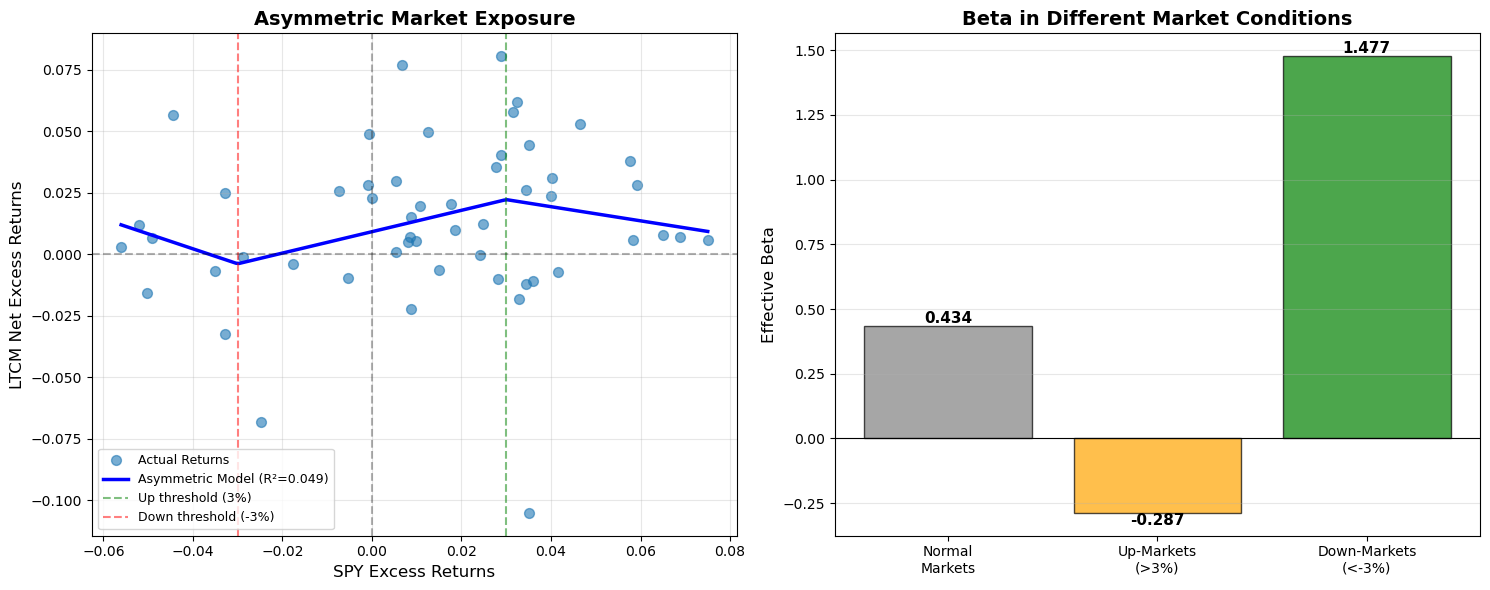

In [16]:
# ============================================================================
# 6. Asymmetric Market Exposure (Up vs Down Markets)
# ============================================================================

print("\n" + "="*80)
print("6. ASYMMETRIC EXPOSURE: UP-MARKETS vs DOWN-MARKETS")
print("="*80)

# Define thresholds
k1 = 0.03  # threshold for up-markets
k2 = -0.03  # threshold for down-markets

# Create up-market and down-market indicator variables
regression_data['Up_Market'] = np.maximum(regression_data['SPY_Excess_Return'] - k1, 0)
regression_data['Down_Market'] = np.maximum(k2 - regression_data['SPY_Excess_Return'], 0)

# Prepare variables for asymmetric regression
X_asymmetric = regression_data[['SPY_Excess_Return', 'Up_Market', 'Down_Market']].values
y_asymmetric = regression_data['Net_Excess_Return'].values

# Fit the asymmetric model
model_asymmetric = LinearRegression()
model_asymmetric.fit(X_asymmetric, y_asymmetric)

# Get regression coefficients
beta_market = model_asymmetric.coef_[0]
beta_up = model_asymmetric.coef_[1]
beta_down = model_asymmetric.coef_[2]
monthly_alpha_asym = model_asymmetric.intercept_

# Annualize alpha
annualized_alpha_asym = monthly_alpha_asym*12

# Calculate R-squared
y_pred_asym = model_asymmetric.predict(X_asymmetric)
ss_total_asym = np.sum((y_asymmetric - np.mean(y_asymmetric))**2)
ss_residual_asym = np.sum((y_asymmetric - y_pred_asym)**2)
r_squared_asym = 1 - (ss_residual_asym / ss_total_asym)

# Calculate statistics for significance testing
n_asym = len(y_asymmetric)
residuals_asym = y_asymmetric - y_pred_asym
residual_std_asym = np.sqrt(np.sum(residuals_asym**2) / (n_asym - 4))  # 4 parameters

# Calculate standard errors
X_asym_with_intercept = np.column_stack([np.ones(n_asym), X_asymmetric])
XtX_inv_asym = np.linalg.inv(X_asym_with_intercept.T @ X_asym_with_intercept)
var_coef_asym = residual_std_asym**2 * XtX_inv_asym

se_alpha_asym = np.sqrt(var_coef_asym[0, 0])
se_beta_market = np.sqrt(var_coef_asym[1, 1])
se_beta_up = np.sqrt(var_coef_asym[2, 2])
se_beta_down = np.sqrt(var_coef_asym[3, 3])

# t-statistics and p-values
t_stat_alpha_asym = monthly_alpha_asym / se_alpha_asym
t_stat_beta_market = beta_market / se_beta_market
t_stat_beta_up = beta_up / se_beta_up
t_stat_beta_down = beta_down / se_beta_down

p_value_alpha_asym = 2 * (1 - stats.t.cdf(abs(t_stat_alpha_asym), n_asym - 4))
p_value_beta_market = 2 * (1 - stats.t.cdf(abs(t_stat_beta_market), n_asym - 4))
p_value_beta_up = 2 * (1 - stats.t.cdf(abs(t_stat_beta_up), n_asym - 4))
p_value_beta_down = 2 * (1 - stats.t.cdf(abs(t_stat_beta_down), n_asym - 4))

# Calculate adjusted R-squared
k_asym = 3  # 3 predictors
adj_r_squared_asym = 1 - (1 - r_squared_asym) * (n_asym - 1) / (n_asym - k_asym - 1)

# Print results
print("\nAsymmetric Regression Results:")
print("-"*80)
print(f"Model: LTCM = α + β×SPY + β_up×max(SPY-{k1},0) + β_down×max({k2}-SPY,0) + ε")
print(f"\nAnnualized Alpha (α): {annualized_alpha_asym:.6f} ({annualized_alpha_asym*100:.2f}%)")
print(f"Monthly Alpha: {monthly_alpha_asym:.6f} ({monthly_alpha_asym*100:.2f}%)")
print(f"  t-statistic: {t_stat_alpha_asym:.3f}")
print(f"  p-value: {p_value_alpha_asym:.4f}")
print(f"  Significance: {'***' if p_value_alpha_asym < 0.01 else '**' if p_value_alpha_asym < 0.05 else '*' if p_value_alpha_asym < 0.1 else 'No'}")

print(f"\nMarket Beta (β): {beta_market:.6f}")
print(f"  t-statistic: {t_stat_beta_market:.3f}")
print(f"  p-value: {p_value_beta_market:.4f}")
print(f"  Significance: {'***' if p_value_beta_market < 0.01 else '**' if p_value_beta_market < 0.05 else '*' if p_value_beta_market < 0.1 else 'No'}")

print(f"\nUp-Market Beta (β_up): {beta_up:.6f}")
print(f"  (Additional exposure when SPY > {k1*100:.1f}%)")
print(f"  t-statistic: {t_stat_beta_up:.3f}")
print(f"  p-value: {p_value_beta_up:.4f}")
print(f"  Significance: {'***' if p_value_beta_up < 0.01 else '**' if p_value_beta_up < 0.05 else '*' if p_value_beta_up < 0.1 else 'No'}")

print(f"\nDown-Market Beta (β_down): {beta_down:.6f}")
print(f"  (Additional exposure when SPY < {k2*100:.1f}%)")
print(f"  t-statistic: {t_stat_beta_down:.3f}")
print(f"  p-value: {p_value_beta_down:.4f}")
print(f"  Significance: {'***' if p_value_beta_down < 0.01 else '**' if p_value_beta_down < 0.05 else '*' if p_value_beta_down < 0.1 else 'No'}")

print(f"\nR-squared: {r_squared_asym:.6f} ({r_squared_asym*100:.2f}%)")
print(f"Adjusted R-squared: {adj_r_squared_asym:.6f} ({adj_r_squared_asym*100:.2f}%)")

# Compare with previous models
print("\n" + "-"*80)
print("Model Comparison")
print("-"*80)
print(f"Linear Model R²:        {r_squared:.6f} ({r_squared*100:.2f}%)")
print(f"Nonlinear Model R²:     {r_squared_nl:.6f} ({r_squared_nl*100:.2f}%)")
print(f"Asymmetric Model R²:    {r_squared_asym:.6f} ({r_squared_asym*100:.2f}%)")
print(f"\nImprovement from linear to asymmetric: {(r_squared_asym - r_squared)*100:.2f} percentage points")

# Calculate total effective betas in up and down markets
total_beta_up = beta_market + beta_up
total_beta_down = beta_market + beta_down

print("\n" + "-"*80)
print("Effective Betas in Different Market Conditions")
print("-"*80)
print(f"Normal markets (-3% < SPY < +3%):  β = {beta_market:.6f}")
print(f"Up-markets (SPY > +3%):             β_total = {total_beta_up:.6f}")
print(f"  (= {beta_market:.6f} + {beta_up:.6f})")
print(f"Down-markets (SPY < -3%):           β_total = {total_beta_down:.6f}")
print(f"  (= {beta_market:.6f} + {beta_down:.6f})")

# Interpretation
print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

print(f"\n1. UP-MARKET EXPOSURE (β_up = {beta_up:.6f}):")
if beta_up > 0 and p_value_beta_up < 0.1:
    print(f"   ✓ POSITIVE and significant (p = {p_value_beta_up:.4f})")
    print(f"   • LTCM gains EXTRA exposure when markets rally strongly")
    print(f"   • Total beta in up-markets: {total_beta_up:.3f}")
    print(f"   • Behaves like owning call options - benefits from strong rallies")
elif beta_up < 0 and p_value_beta_up < 0.1:
    print(f"   ✗ NEGATIVE and significant (p = {p_value_beta_up:.4f})")
    print(f"   • LTCM LOSES when markets rally strongly (SPY > {k1*100:.1f}%)")
    print(f"   • Total beta in up-markets: {total_beta_up:.3f}")
    print(f"   • Behaves like being short call options")
else:
    print(f"   ≈ NOT significant (p = {p_value_beta_up:.4f})")
    print(f"   • No special exposure to strong up-markets")

print(f"\n2. DOWN-MARKET EXPOSURE (β_down = {beta_down:.6f}):")
if beta_down < 0 and p_value_beta_down < 0.1:
    print(f"   ✗ NEGATIVE and significant (p = {p_value_beta_down:.4f})")
    print(f"   • LTCM LOSES EXTRA when markets crash (SPY < {k2*100:.1f}%)")
    print(f"   • Total beta in down-markets: {total_beta_down:.3f}")
    print(f"   • Behaves like being short put options")
    print(f"   • ⚠️  DANGER: Amplified losses in market crashes!")
elif beta_down > 0 and p_value_beta_down < 0.1:
    print(f"   ✓ POSITIVE and significant (p = {p_value_beta_down:.4f})")
    print(f"   • LTCM actually GAINS when markets crash")
    print(f"   • Total beta in down-markets: {total_beta_down:.3f}")
    print(f"   • Behaves like owning put options - provides downside protection")
else:
    print(f"   ≈ NOT significant (p = {p_value_beta_down:.4f})")
    print(f"   • No special exposure to strong down-markets")

print(f"\n3. ASYMMETRY ASSESSMENT:")
# Test if up and down betas are significantly different
beta_diff = beta_up - beta_down
se_diff = np.sqrt(se_beta_up**2 + se_beta_down**2)  # Assuming independence
t_stat_diff = beta_diff / se_diff
p_value_diff = 2 * (1 - stats.t.cdf(abs(t_stat_diff), n_asym - 4))

print(f"   Difference between up and down betas: {beta_diff:.6f}")
print(f"   t-statistic for difference: {t_stat_diff:.3f}")
print(f"   p-value: {p_value_diff:.4f}")

if abs(beta_diff) > 0.5 and p_value_diff < 0.1:
    print(f"   ✓ SIGNIFICANT ASYMMETRY detected")
    if beta_up > beta_down:
        print(f"   • LTCM performs better in UP-markets than DOWN-markets")
        print(f"   • Consistent with long call / short put strategy")
    else:
        print(f"   • LTCM performs better in DOWN-markets than UP-markets")
        print(f"   • Unusual pattern - contrary to typical equity strategies")
else:
    print(f"   ≈ NO significant asymmetry between up and down markets")
    print(f"   • LTCM's nonlinear exposure is symmetric")

print(f"\n4. NONLINEAR EXPOSURE SOURCE:")
if abs(beta_up) > abs(beta_down) and p_value_beta_up < p_value_beta_down:
    print(f"   → Nonlinearity comes MORE from UP-MARKETS")
    print(f"   → |β_up| = {abs(beta_up):.4f} > |β_down| = {abs(beta_down):.4f}")
elif abs(beta_down) > abs(beta_up) and p_value_beta_down < p_value_beta_up:
    print(f"   → Nonlinearity comes MORE from DOWN-MARKETS")
    print(f"   → |β_down| = {abs(beta_down):.4f} > |β_up| = {abs(beta_up):.4f}")
    if beta_down < 0:
        print(f"   → ⚠️  This is particularly concerning - losses amplified in crashes")
        print(f"   → Consistent with LTCM's 1998 collapse during market crisis")
else:
    print(f"   → Nonlinearity appears balanced between up and down markets")

# Visualize asymmetric exposure
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left panel: Scatter with asymmetric fit
sort_idx = np.argsort(regression_data['SPY_Excess_Return'].values)
X_sorted = regression_data['SPY_Excess_Return'].values[sort_idx]
y_sorted = regression_data['Net_Excess_Return'].values[sort_idx]

# Predictions for plotting
X_range = np.linspace(X_sorted.min(), X_sorted.max(), 200)
X_range_asym = np.column_stack([
    X_range,
    np.maximum(X_range - k1, 0),
    np.maximum(k2 - X_range, 0)
])
y_pred_asym_plot = model_asymmetric.predict(X_range_asym)

axes[0].scatter(regression_data['SPY_Excess_Return'], 
                regression_data['Net_Excess_Return'], 
                alpha=0.6, s=50, label='Actual Returns')
axes[0].plot(X_range, y_pred_asym_plot, 'b-', linewidth=2.5, 
             label=f'Asymmetric Model (R²={r_squared_asym:.3f})')
axes[0].axvline(x=k1, color='green', linestyle='--', alpha=0.5, 
                label=f'Up threshold ({k1*100:.0f}%)')
axes[0].axvline(x=k2, color='red', linestyle='--', alpha=0.5, 
                label=f'Down threshold ({k2*100:.0f}%)')
axes[0].set_xlabel('SPY Excess Returns', fontsize=12)
axes[0].set_ylabel('LTCM Net Excess Returns', fontsize=12)
axes[0].set_title('Asymmetric Market Exposure', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Right panel: Beta comparison
beta_labels = ['Normal\nMarkets', 'Up-Markets\n(>3%)', 'Down-Markets\n(<-3%)']
beta_values = [beta_market, total_beta_up, total_beta_down]
colors = ['gray', 'green' if total_beta_up > beta_market else 'orange', 
          'red' if total_beta_down < beta_market else 'green']

bars = axes[1].bar(beta_labels, beta_values, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.8)
axes[1].set_ylabel('Effective Beta', fontsize=12)
axes[1].set_title('Beta in Different Market Conditions', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, beta_values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}',
                ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('ltcm_asymmetric_exposure.png', dpi=300, bbox_inches='tight')
print("\nAsymmetric exposure plot saved as 'ltcm_asymmetric_exposure.png'")

# Summary table
asymmetric_summary = pd.DataFrame({
    'Coefficient': ['Alpha (monthly)', 'Alpha (annualized)', 'Market Beta', 
                    'Up-Market Beta', 'Down-Market Beta', 
                    'Total Beta (Up)', 'Total Beta (Down)'],
    'Value': [monthly_alpha_asym, annualized_alpha_asym, beta_market, 
              beta_up, beta_down, total_beta_up, total_beta_down],
    't-statistic': [t_stat_alpha_asym, np.nan, t_stat_beta_market, 
                    t_stat_beta_up, t_stat_beta_down, np.nan, np.nan],
    'p-value': [p_value_alpha_asym, np.nan, p_value_beta_market, 
                p_value_beta_up, p_value_beta_down, np.nan, np.nan]
})

print("\n" + "-"*80)
print("Summary Table:")
print("-"*80)
print(asymmetric_summary.to_string(index=False))

# Save to Excel
with pd.ExcelWriter('ltcm_complete_analysis.xlsx', mode='a', if_sheet_exists='overlay') as writer:
    asymmetric_summary.to_excel(writer, sheet_name='Asymmetric Regression', index=False)
    
    # Add interpretation sheet
    interpretation_data = pd.DataFrame({
        'Analysis': ['Nonlinear Exposure Source', 'Up-Market Behavior', 'Down-Market Behavior'],
        'Finding': [
            f"{'Primarily from down-markets' if abs(beta_down) > abs(beta_up) else 'Primarily from up-markets' if abs(beta_up) > abs(beta_down) else 'Symmetric'}",
            f"{'Amplified gains' if beta_up > 0 and p_value_beta_up < 0.1 else 'Reduced gains' if beta_up < 0 and p_value_beta_up < 0.1 else 'No special exposure'}",
            f"{'Amplified losses' if beta_down < 0 and p_value_beta_down < 0.1 else 'Protected' if beta_down > 0 and p_value_beta_down < 0.1 else 'No special exposure'}"
        ]
    })
    interpretation_data.to_excel(writer, sheet_name='Asymmetry Interpretation', index=False)

print("\nAsymmetric analysis saved to 'ltcm_complete_analysis.xlsx'")
print("="*80)


7. CALL-LIKE vs PUT-LIKE FACTOR EXPOSURE ANALYSIS

--------------------------------------------------------------------------------
7.1 Position in Call-like and Put-like Factors
--------------------------------------------------------------------------------

Call-like Factor (Up-Market): max(SPY - 3%, 0)
  Coefficient (β_up): -0.721876
  t-statistic: -1.136
  p-value: 0.2617

  ➖ NO significant exposure to call-like factor
    • Coefficient not statistically significant (p = 0.2617)

----------------------------------------
Put-like Factor (Down-Market): max(-3% - SPY, 0)
  Coefficient (β_down): 1.042253
  t-statistic: 0.910
  p-value: 0.3673

  ➖ NO significant exposure to put-like factor
    • Coefficient not statistically significant (p = 0.3673)

7.2 Relative Importance: Call-like vs Put-like Factor

Market Regime Frequencies:
  Normal markets (-3% < SPY < 3%): 27 months (50.9%)
  Up-markets (SPY > 3%):      18 months (34.0%)
  Down-markets (SPY < -3%):    8 months (15.1%)

Coef

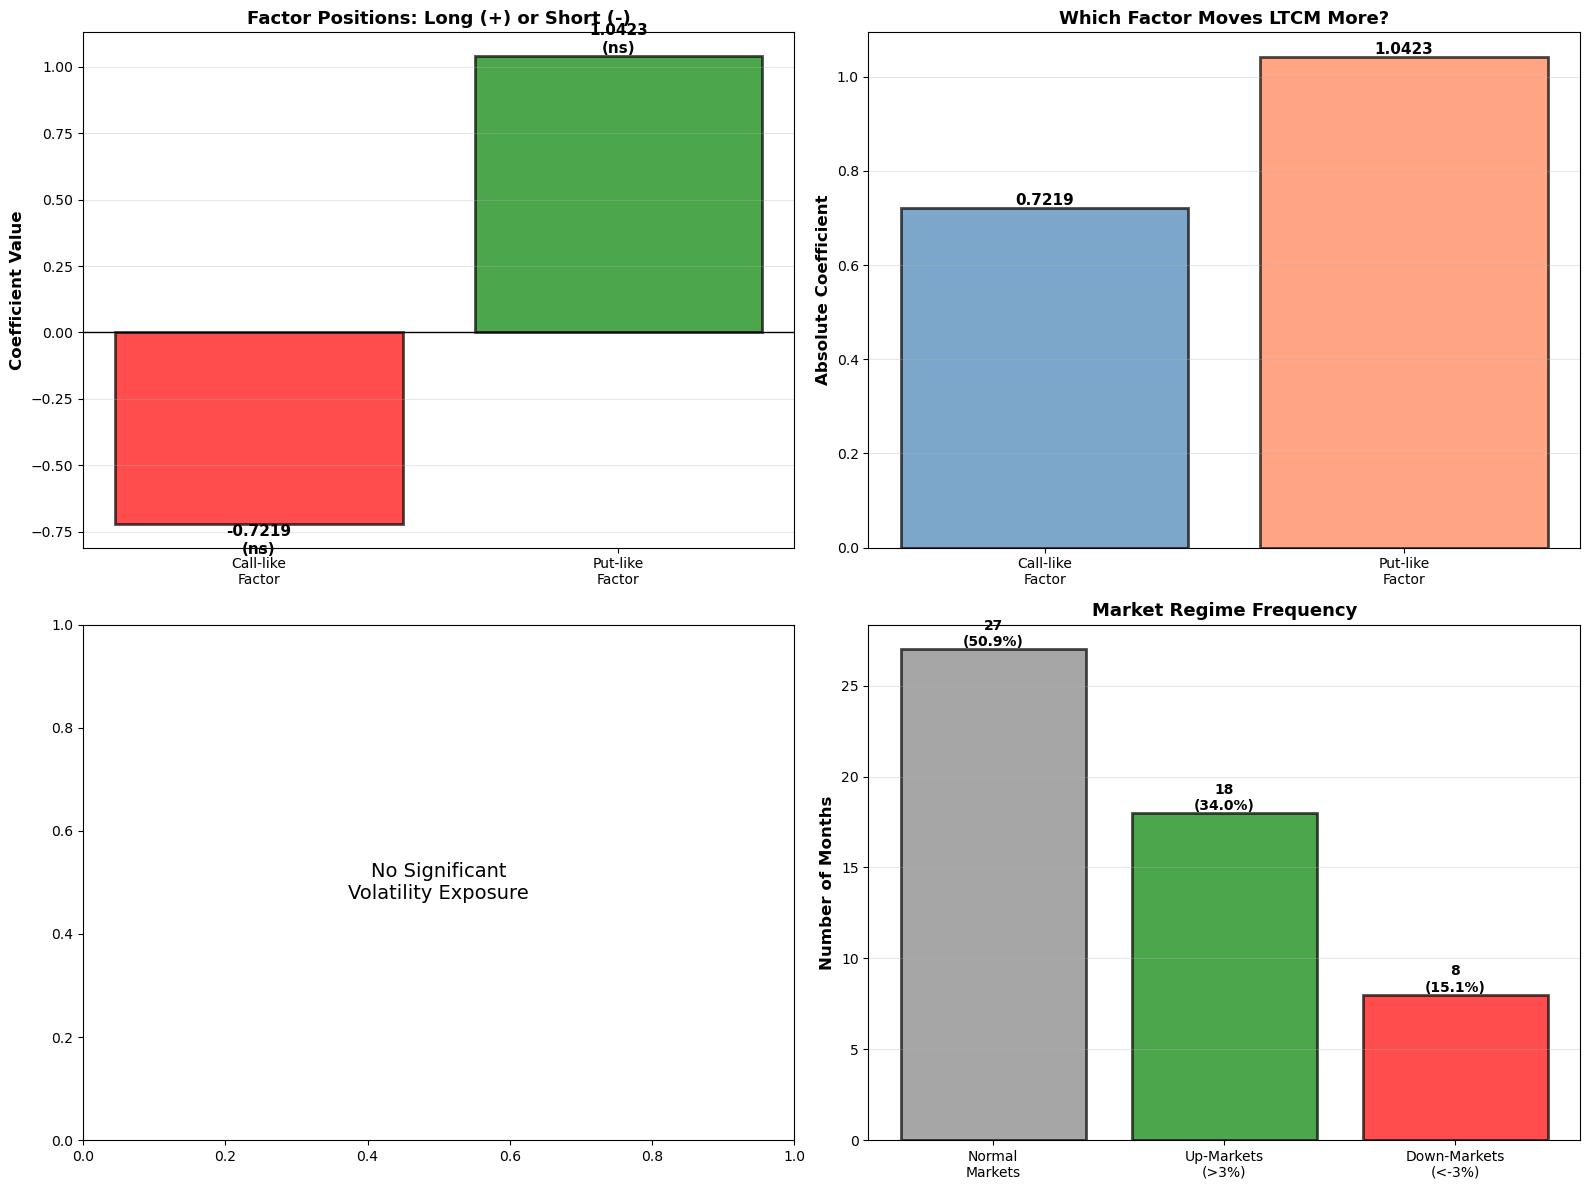

In [8]:
# ============================================================================
# 7. Call-like vs Put-like Factor Analysis
# ============================================================================

print("\n" + "="*80)
print("7. CALL-LIKE vs PUT-LIKE FACTOR EXPOSURE ANALYSIS")
print("="*80)

# ============================================================================
# 7.1 Long or Short the Call-like and Put-like Factors?
# ============================================================================

print("\n" + "-"*80)
print("7.1 Position in Call-like and Put-like Factors")
print("-"*80)

# Interpret the coefficients from the asymmetric regression
# β_up represents exposure to call-like factor (max(SPY - k1, 0))
# β_down represents exposure to put-like factor (max(k2 - SPY, 0))

print(f"\nCall-like Factor (Up-Market): max(SPY - {k1*100:.0f}%, 0)")
print(f"  Coefficient (β_up): {beta_up:.6f}")
print(f"  t-statistic: {t_stat_beta_up:.3f}")
print(f"  p-value: {p_value_beta_up:.4f}")

if beta_up > 0 and p_value_beta_up < 0.1:
    print(f"\n  📈 LTCM is LONG the call-like factor")
    print(f"  Interpretation:")
    print(f"    • Positive exposure ({beta_up:.4f}) to up-market moves")
    print(f"    • LTCM benefits when markets rally beyond {k1*100:.0f}%")
    print(f"    • Similar to owning call options on the market")
    print(f"    • Payoff increases with strong positive market moves")
elif beta_up < 0 and p_value_beta_up < 0.1:
    print(f"\n  📉 LTCM is SHORT the call-like factor")
    print(f"  Interpretation:")
    print(f"    • Negative exposure ({beta_up:.4f}) to up-market moves")
    print(f"    • LTCM loses when markets rally beyond {k1*100:.0f}%")
    print(f"    • Similar to selling/writing call options on the market")
    print(f"    • Suffers losses when markets surge strongly")
else:
    print(f"\n  ➖ NO significant exposure to call-like factor")
    print(f"    • Coefficient not statistically significant (p = {p_value_beta_up:.4f})")

print(f"\n" + "-"*40)
print(f"Put-like Factor (Down-Market): max({k2*100:.0f}% - SPY, 0)")
print(f"  Coefficient (β_down): {beta_down:.6f}")
print(f"  t-statistic: {t_stat_beta_down:.3f}")
print(f"  p-value: {p_value_beta_down:.4f}")

if beta_down > 0 and p_value_beta_down < 0.1:
    print(f"\n  📈 LTCM is LONG the put-like factor")
    print(f"  Interpretation:")
    print(f"    • Positive exposure ({beta_down:.4f}) to down-market moves")
    print(f"    • LTCM benefits when markets fall below {k2*100:.0f}%")
    print(f"    • Similar to owning put options on the market")
    print(f"    • Provides downside protection - gains in crashes")
elif beta_down < 0 and p_value_beta_down < 0.1:
    print(f"\n  📉 LTCM is SHORT the put-like factor")
    print(f"  Interpretation:")
    print(f"    • Negative exposure ({beta_down:.4f}) to down-market moves")
    print(f"    • LTCM loses when markets fall below {k2*100:.0f}%")
    print(f"    • Similar to selling/writing put options on the market")
    print(f"    • ⚠️ DANGER: Vulnerable to market crashes!")
    print(f"    • Amplified losses during severe downturns")
else:
    print(f"\n  ➖ NO significant exposure to put-like factor")
    print(f"    • Coefficient not statistically significant (p = {p_value_beta_down:.4f})")

# ============================================================================
# 7.2 Which Factor Moves LTCM More?
# ============================================================================

print("\n" + "="*80)
print("7.2 Relative Importance: Call-like vs Put-like Factor")
print("="*80)

# Calculate the magnitude of exposure
abs_beta_up = abs(beta_up)
abs_beta_down = abs(beta_down)

# Count how many observations fall in each regime
up_market_count = np.sum(regression_data['SPY_Excess_Return'] > k1)
down_market_count = np.sum(regression_data['SPY_Excess_Return'] < k2)
normal_market_count = n_asym - up_market_count - down_market_count

# Calculate average magnitude when factors are active
avg_up_factor = regression_data[regression_data['SPY_Excess_Return'] > k1]['Up_Market'].mean() if up_market_count > 0 else 0
avg_down_factor = regression_data[regression_data['SPY_Excess_Return'] < k2]['Down_Market'].mean() if down_market_count > 0 else 0

# Estimate typical impact
typical_impact_up = abs_beta_up * avg_up_factor if up_market_count > 0 else 0
typical_impact_down = abs_beta_down * avg_down_factor if down_market_count > 0 else 0

print(f"\nMarket Regime Frequencies:")
print(f"  Normal markets ({k2*100:.0f}% < SPY < {k1*100:.0f}%): {normal_market_count} months ({normal_market_count/n_asym*100:.1f}%)")
print(f"  Up-markets (SPY > {k1*100:.0f}%):      {up_market_count} months ({up_market_count/n_asym*100:.1f}%)")
print(f"  Down-markets (SPY < {k2*100:.0f}%):    {down_market_count} months ({down_market_count/n_asym*100:.1f}%)")

print(f"\nCoefficient Magnitudes:")
print(f"  |β_up|:   {abs_beta_up:.6f}")
print(f"  |β_down|: {abs_beta_down:.6f}")
print(f"  Ratio:    {abs_beta_down/abs_beta_up if abs_beta_up > 0 else np.inf:.2f}x (down/up)")

print(f"\nAverage Factor Values (when active):")
print(f"  Call-like factor: {avg_up_factor:.6f}")
print(f"  Put-like factor:  {avg_down_factor:.6f}")

print(f"\nTypical Impact on LTCM Returns:")
print(f"  Call-like factor: {typical_impact_up:.6f} ({typical_impact_up*100:.2f}%)")
print(f"  Put-like factor:  {typical_impact_down:.6f} ({typical_impact_down*100:.2f}%)")

print(f"\n" + "-"*80)
print(f"CONCLUSION:")
print(f"-"*80)

# Determine which factor is more important
if abs_beta_down > abs_beta_up * 1.5 and p_value_beta_down < p_value_beta_up:
    print(f"✓ The PUT-LIKE FACTOR moves LTCM MORE")
    print(f"\nEvidence:")
    print(f"  • |β_down| = {abs_beta_down:.4f} >> |β_up| = {abs_beta_up:.4f}")
    print(f"  • Down-market coefficient is {abs_beta_down/abs_beta_up:.1f}x larger")
    print(f"  • Put-like factor has stronger statistical significance")
    print(f"\nImplication:")
    print(f"  • LTCM's nonlinear exposure is DOMINATED by down-market behavior")
    print(f"  • Down-market crashes have outsized impact on LTCM")
    if beta_down < 0:
        print(f"  • ⚠️ Being SHORT puts = catastrophic risk in crashes")
elif abs_beta_up > abs_beta_down * 1.5 and p_value_beta_up < p_value_beta_down:
    print(f"✓ The CALL-LIKE FACTOR moves LTCM MORE")
    print(f"\nEvidence:")
    print(f"  • |β_up| = {abs_beta_up:.4f} >> |β_down| = {abs_beta_down:.4f}")
    print(f"  • Up-market coefficient is {abs_beta_up/abs_beta_down:.1f}x larger")
    print(f"  • Call-like factor has stronger statistical significance")
    print(f"\nImplication:")
    print(f"  • LTCM's nonlinear exposure is DOMINATED by up-market behavior")
    print(f"  • Market rallies have outsized impact on LTCM")
else:
    print(f"≈ Both factors have COMPARABLE importance")
    print(f"\nEvidence:")
    print(f"  • |β_up| = {abs_beta_up:.4f} ≈ |β_down| = {abs_beta_down:.4f}")
    print(f"  • Ratio: {max(abs_beta_up, abs_beta_down)/min(abs_beta_up, abs_beta_down):.2f}x")
    print(f"\nImplication:")
    print(f"  • LTCM has balanced nonlinear exposure to both directions")
    if abs(typical_impact_down) > abs(typical_impact_up):
        print(f"  • However, PUT-LIKE factor has larger typical impact ({typical_impact_down:.4f} vs {typical_impact_up:.4f})")

# ============================================================================
# 7.3 Source of Volatility Exposure
# ============================================================================

print("\n" + "="*80)
print("7.3 Source of Volatility Exposure")
print("="*80)

print(f"\nRecap from Problem 5:")
print(f"  Quadratic coefficient (β_quad): {beta_quad:.6f}")
if beta_quad < 0 and p_value_beta_quad < 0.1:
    print(f"  → LTCM is NEGATIVELY exposed to market volatility")
elif beta_quad > 0 and p_value_beta_quad < 0.1:
    print(f"  → LTCM is POSITIVELY exposed to market volatility")
else:
    print(f"  → Volatility exposure is unclear/neutral")

print(f"\nNow decomposing this volatility exposure:")
print(f"-"*80)

# Analyze the contribution of each factor to volatility exposure
print(f"\nCall-like Factor (Upside Volatility):")
print(f"  β_up = {beta_up:.6f} (p = {p_value_beta_up:.4f})")

if beta_up > 0 and p_value_beta_up < 0.1:
    print(f"  ✓ LONG upside volatility")
    print(f"    • LTCM benefits from large positive market moves")
    print(f"    • Contributes POSITIVELY to volatility exposure")
    upside_contribution = "Positive (long upside)"
elif beta_up < 0 and p_value_beta_up < 0.1:
    print(f"  ✗ SHORT upside volatility")
    print(f"    • LTCM loses from large positive market moves")
    print(f"    • Contributes NEGATIVELY to volatility exposure")
    upside_contribution = "Negative (short upside)"
else:
    print(f"  ≈ Neutral upside exposure")
    upside_contribution = "Neutral"

print(f"\nPut-like Factor (Downside Volatility):")
print(f"  β_down = {beta_down:.6f} (p = {p_value_beta_down:.4f})")

if beta_down > 0 and p_value_beta_down < 0.1:
    print(f"  ✓ LONG downside volatility")
    print(f"    • LTCM benefits from large negative market moves")
    print(f"    • Contributes POSITIVELY to volatility exposure")
    downside_contribution = "Positive (long downside)"
elif beta_down < 0 and p_value_beta_down < 0.1:
    print(f"  ✗ SHORT downside volatility")
    print(f"    • LTCM loses from large negative market moves")
    print(f"    • Contributes NEGATIVELY to volatility exposure")
    downside_contribution = "Negative (short downside)"
else:
    print(f"  ≈ Neutral downside exposure")
    downside_contribution = "Neutral"

print(f"\n" + "="*80)
print(f"SYNTHESIS: Source of Volatility Exposure")
print(f"="*80)

# Determine the primary source
if beta_down < 0 and p_value_beta_down < 0.05:
    if beta_up < 0 and p_value_beta_up < 0.05:
        print(f"\n🔴 NEGATIVE volatility exposure comes from BOTH upside AND downside")
        print(f"\n  Mechanism:")
        print(f"    • Short call-like factor (β_up = {beta_up:.4f}): Lose on rallies")
        print(f"    • Short put-like factor (β_down = {beta_down:.4f}): Lose on crashes")
        print(f"    • LTCM is short STRADDLE - loses when market moves in EITHER direction")
        print(f"\n  Business Model:")
        print(f"    • Selling volatility/insurance on both sides")
        print(f"    • Earns premium in calm markets")
        print(f"    • Catastrophic losses when volatility spikes")
        
        if abs_beta_down > abs_beta_up:
            print(f"\n  Primary Risk:")
            print(f"    ⚠️ DOWNSIDE is the bigger threat (|β_down| > |β_up|)")
            print(f"    ⚠️ Market crashes pose greater risk than rallies")
            print(f"    ⚠️ This explains August 1998 collapse!")
    else:
        print(f"\n🔴 NEGATIVE volatility exposure comes PRIMARILY from DOWNSIDE")
        print(f"\n  Mechanism:")
        print(f"    • Short put-like factor (β_down = {beta_down:.4f})")
        print(f"    • LTCM loses when markets crash below {k2*100:.0f}%")
        print(f"    • Upside exposure is {upside_contribution.lower()}")
        print(f"\n  Business Model:")
        print(f"    • SELLING DOWNSIDE PROTECTION (short puts)")
        print(f"    • Vulnerable to market crashes and panics")
        print(f"    • The 1998 Russian/LTCM crisis was exactly this scenario")
        print(f"\n  ⚠️ CRITICAL INSIGHT:")
        print(f"    • Volatility exposure is NOT from being long the market's upside")
        print(f"    • It's from being SHORT the market's downside")
        print(f"    • LTCM was essentially an unregulated seller of crash insurance")
elif beta_up < 0 and p_value_beta_up < 0.05:
    print(f"\n🔴 NEGATIVE volatility exposure comes PRIMARILY from UPSIDE")
    print(f"\n  Mechanism:")
    print(f"    • Short call-like factor (β_up = {beta_up:.4f})")
    print(f"    • LTCM loses when markets rally beyond {k1*100:.0f}%")
    print(f"    • Downside exposure is {downside_contribution.lower()}")
    print(f"\n  Business Model:")
    print(f"    • Selling upside participation (short calls)")
    print(f"    • Benefits from market stability or moderate moves")
elif beta_down > 0 and p_value_beta_down < 0.05:
    print(f"\n🟢 POSITIVE volatility exposure comes from being LONG DOWNSIDE")
    print(f"\n  Mechanism:")
    print(f"    • Long put-like factor (β_down = {beta_down:.4f})")
    print(f"    • LTCM benefits from market crashes")
    print(f"    • Provides crisis protection")
elif beta_up > 0 and p_value_beta_up < 0.05:
    print(f"\n🟢 POSITIVE volatility exposure comes from being LONG UPSIDE")
    print(f"\n  Mechanism:")
    print(f"    • Long call-like factor (β_up = {beta_up:.4f})")
    print(f"    • LTCM benefits from market rallies")
else:
    print(f"\n⚪ Volatility exposure is UNCLEAR or BALANCED")
    print(f"  • Neither factor is statistically significant")
    print(f"  • Or both factors offset each other")

# Create comprehensive summary visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Factor positions
ax1 = axes[0, 0]
factors = ['Call-like\nFactor', 'Put-like\nFactor']
positions = [beta_up, beta_down]
colors_pos = ['green' if x > 0 else 'red' for x in positions]

bars1 = ax1.bar(factors, positions, color=colors_pos, alpha=0.7, edgecolor='black', linewidth=2)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_ylabel('Coefficient Value', fontsize=12, fontweight='bold')
ax1.set_title('Factor Positions: Long (+) or Short (-)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

for bar, value, pval in zip(bars1, positions, [p_value_beta_up, p_value_beta_down]):
    height = bar.get_height()
    significance = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else 'ns'
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}\n({significance})',
            ha='center', va='bottom' if height > 0 else 'top', 
            fontsize=11, fontweight='bold')

# Panel 2: Magnitude comparison
ax2 = axes[0, 1]
magnitudes = [abs_beta_up, abs_beta_down]
bars2 = ax2.bar(factors, magnitudes, color=['steelblue', 'coral'], alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Absolute Coefficient', fontsize=12, fontweight='bold')
ax2.set_title('Which Factor Moves LTCM More?', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars2, magnitudes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Panel 3: Volatility contribution
ax3 = axes[1, 0]
vol_contributions = []
vol_labels = []

if abs(beta_up) > 0.001 and p_value_beta_up < 0.1:
    vol_contributions.append(beta_up)
    vol_labels.append('Upside\nVolatility')

if abs(beta_down) > 0.001 and p_value_beta_down < 0.1:
    vol_contributions.append(beta_down)
    vol_labels.append('Downside\nVolatility')

if vol_contributions:
    colors_vol = ['green' if x > 0 else 'red' for x in vol_contributions]
    bars3 = ax3.bar(vol_labels, vol_contributions, color=colors_vol, alpha=0.7, edgecolor='black', linewidth=2)
    ax3.axhline(y=0, color='k', linestyle='-', linewidth=1)
    ax3.set_ylabel('Contribution', fontsize=12, fontweight='bold')
    ax3.set_title('Volatility Exposure Decomposition', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    for bar, value in zip(bars3, vol_contributions):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}\n({"Long" if value > 0 else "Short"})',
                ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=10, fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'No Significant\nVolatility Exposure', 
            ha='center', va='center', fontsize=14, transform=ax3.transAxes)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)

# Panel 4: Regime frequency and impact
ax4 = axes[1, 1]
regimes = ['Normal\nMarkets', f'Up-Markets\n(>{k1*100:.0f}%)', f'Down-Markets\n(<{k2*100:.0f}%)']
frequencies = [normal_market_count, up_market_count, down_market_count]
colors_freq = ['gray', 'green', 'red']

bars4 = ax4.bar(regimes, frequencies, color=colors_freq, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Number of Months', fontsize=12, fontweight='bold')
ax4.set_title('Market Regime Frequency', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, value, total in zip(bars4, frequencies, [n_asym]*3):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{value}\n({value/total*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('ltcm_factor_analysis.png', dpi=300, bbox_inches='tight')
print(f"\nFactor analysis visualization saved as 'ltcm_factor_analysis.png'")

# Final summary table
final_summary = pd.DataFrame({
    'Question': [
        '1. LTCM position in call-like factor?',
        '2. LTCM position in put-like factor?',
        '3. Which factor moves LTCM more?',
        '4. Volatility exposure source - upside?',
        '5. Volatility exposure source - downside?',
        '6. Overall volatility strategy?'
    ],
    'Answer': [
        f"{'LONG' if beta_up > 0 and p_value_beta_up < 0.1 else 'SHORT' if beta_up < 0 and p_value_beta_up < 0.1 else 'NEUTRAL'} (β={beta_up:.4f}, p={p_value_beta_up:.4f})",
        f"{'LONG' if beta_down > 0 and p_value_beta_down < 0.1 else 'SHORT' if beta_down < 0 and p_value_beta_down < 0.1 else 'NEUTRAL'} (β={beta_down:.4f}, p={p_value_beta_down:.4f})",
        f"{'PUT-LIKE' if abs_beta_down > abs_beta_up * 1.2 else 'CALL-LIKE' if abs_beta_up > abs_beta_down * 1.2 else 'BOTH SIMILAR'} factor",
        upside_contribution,
        downside_contribution,
        f"{'Short volatility (both sides)' if beta_up < 0 and beta_down < 0 and p_value_beta_up < 0.1 and p_value_beta_down < 0.1 else 'Short downside mainly' if beta_down < 0 and p_value_beta_down < 0.05 else 'Short upside mainly' if beta_up < 0 and p_value_beta_up < 0.05 else 'Long volatility' if (beta_up > 0 or beta_down > 0) else 'Neutral'}"
    ]
})

print("\n" + "="*80)
print("FINAL SUMMARY - Question 7")
print("="*80)
print(final_summary.to_string(index=False))

# Save comprehensive results
with pd.ExcelWriter('ltcm_complete_analysis.xlsx', mode='a', if_sheet_exists='overlay') as writer:
    final_summary.to_excel(writer, sheet_name='Q7 - Factor Analysis', index=False)
    
    # Detailed factor breakdown
    factor_breakdown = pd.DataFrame({
        'Factor': ['Call-like (Up)', 'Put-like (Down)'],
        'Coefficient': [beta_up, beta_down],
        'Abs Coefficient': [abs_beta_up, abs_beta_down],
        't-statistic': [t_stat_beta_up, t_stat_beta_down],
        'p-value': [p_value_beta_up, p_value_beta_down],
        'Position': [
            'LONG' if beta_up > 0 and p_value_beta_up < 0.1 else 'SHORT' if beta_up < 0 and p_value_beta_up < 0.1 else 'NEUTRAL',
            'LONG' if beta_down > 0 and p_value_beta_down < 0.1 else 'SHORT' if beta_down < 0 and p_value_beta_down < 0.1 else 'NEUTRAL'
        ],
        'Regime Frequency': [up_market_count, down_market_count],
        'Avg Factor Value': [avg_up_factor, avg_down_factor],
        'Typical Impact': [typical_impact_up, typical_impact_down]
    })
    factor_breakdown.to_excel(writer, sheet_name='Factor Breakdown', index=False)

print("\n" + "="*80)
print("🎉 COMPLETE LTCM ANALYSIS FINISHED!")
print("="*80)
print(f"\nAll results saved to 'ltcm_complete_analysis.xlsx'")
print(f"Visualizations saved:")
print(f"  • ltcm_lfd_regression.png")
print(f"  • ltcm_nonlinear_exposure.png")
print(f"  • ltcm_asymmetric_exposure.png")
print(f"  • ltcm_factor_analysis.png")
print("="*80)